In [16]:
import pandas as pd
import numpy as np
import types
import os

In [2]:
from lfs.helper import *
from lfs.lf_categorical import *
from lfs.lf_extration import *
from lfs.lf_numerical import *
from lfs.lf_unusable import *
from lfs.lf_mixed_class import *

In [3]:
number_of_files = 1000
base_dir = 'data/labels/'
ext = '.xlsx'
df = pd.DataFrame()
for file_name in os.listdir(base_dir):
    if number_of_files < 0: break
    if not file_name.endswith(ext): continue
    number_of_files -= 1
    print('reading files', file_name)
    df = df.append(pd.read_excel(base_dir + file_name))

reading files data_for_labelling4.xlsx
reading files data_for_labelling8.xlsx
reading files data_for_labelling9.xlsx
reading files data_for_labelling5.xlsx
reading files data_for_labelling3.xlsx
reading files data_for_labelling2.csv.xlsx
reading files data_for_labelling6 (1) (1).xlsx
reading files data_for_labelling1.csv.xlsx
reading files data_for_labelling0.csv.xlsx
reading files data_for_labelling7.xlsx


In [4]:
cols = df.columns.tolist()
print(cols)

['% nans', 'Attribute_name', 'Check', 'Num of nans', 'Reason', 'Record_id', 'Total_val', 'Unnamed: 2', 'Unnamed: 9', 'check', 'max_val', 'mean', 'min_val', 'num of dist_val', 'reason', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'std_dev', 'y_Arun', 'y_act', 'y_pred']


In [5]:
df['% nans'] = df['Num of nans'] / df['Total_val']

In [6]:
cols = ['y_act','Reason','Attribute_name','Total_val','num of dist_val','% nans'] + cols[10:13] + ['std_dev'] + cols[15:-4]

In [7]:
df = df.reindex(columns=cols)
df[:1]

,y_act,Reason,Attribute_name,Total_val,num of dist_val,% nans,max_val,mean,min_val,std_dev,sample_1,sample_2,sample_3,sample_4,sample_5
0,Unusable,l,StratificationCategory2,403984,1,0.803648,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [8]:
print(df.columns.tolist())

['y_act', 'Reason', 'Attribute_name', 'Total_val', 'num of dist_val', '% nans', 'max_val', 'mean', 'min_val', 'std_dev', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']


In [9]:
df[df.columns.tolist()[-5:]] = df[df.columns.tolist()[-5:]].astype(str)

In [10]:
df.y_act.unique()

array(['Unusable', 'Usable with extraction',
       'Usable directly categorical', 'Context_specific',
       'Usable directly numeric', 'Usable Directly Numeric',
       'Usable Directly Categorical', 'Usable with Extraction',
       'Usable Directly Categorical ', 'Usable with Extration',
       'Usable With Extraction', 'Usable with Extraction ', 'unusable',
       'Usable Directly numeric', 'Usable directly Categorical',
       'Usable Directly categorical'], dtype=object)

In [11]:
df['y_act'] = df.apply(lambda row: label_mapper(row), axis=1)

In [12]:
categories = {'Usable Directly Categorical':    1, 
              'Usable Directly Numeric':        2, 
              'Usable With Extraction':         3, 
              'Unusable':                       4, 
              'Context_Specific':               5, 
              'None':                           0
              }
categories_size = {'Context_Specific':              2050,
                   'Unusable':                      891,
                   'Usable Directly Categorical':   2087,
                   'Usable Directly Numeric':       5063,
                   'Usable With Extraction':        650
                   }

In [13]:
df = df[df.y_act != 'Context_Specific']

In [14]:
df.y_act.unique()

array(['Unusable', 'Usable With Extraction',
       'Usable Directly Categorical', 'Usable Directly Numeric'],
      dtype=object)

## LABELING FUNCTIONS

In [17]:
all_lfs = [f for f in globals().values() if type(f) == types.FunctionType]
lf_extra_list = [f for f in all_lfs if f.__module__ == 'lfs.lf_extration']
lf_cate_list = [f for f in all_lfs if f.__module__ == 'lfs.lf_categorical']
lf_num_list = [f for f in all_lfs if f.__module__ == 'lfs.lf_numerical']
lf_unuse_list = [f for f in all_lfs if f.__module__ == 'lfs.lf_unusable']
lf_mixed_list = [f for f in all_lfs if f.__module__ == 'lfs.lf_mixed_class']
len(lf_extra_list),len(lf_cate_list),len(lf_num_list),len(lf_unuse_list),len(lf_mixed_list)

(10, 10, 6, 3, 1)

In [18]:
total_lfs = lf_extra_list + lf_cate_list + lf_num_list + lf_unuse_list + lf_mixed_list
len(total_lfs)

30

In [20]:
n, m = len(df), len(total_lfs)
n, m

(8691, 30)

In [24]:
Ls = np.zeros((n,m), dtype=int)
j = -1
for lf in total_lfs:
    j += 1
    i = -1
    for index, row in df.iterrows():
        i += 1
        Ls[i][j] = lf(row)

In [25]:
np.savetxt('lf_outs.txt', Ls, fmt='%i')

In [26]:
from collections import Counter
from collections import defaultdict
def take_mode(row):
    occ_map = Counter(row)
    occ_map.pop(0,None)
    rev_map = defaultdict(list)
    for k, v in occ_map.items():
        rev_map[v].append(k)
    rev_tuple = [(k, v) for k, v in rev_map.items()]
    rev_tuple.sort(key=lambda x:-x[0])
    if len(rev_tuple):
        return np.random.choice(rev_tuple[0][1])
    else:
        return np.random.randint(1,5)

In [27]:
modes = np.apply_along_axis(take_mode, 1, Ls)

In [28]:
np.unique(modes)

array([1, 2, 3, 4])

In [29]:
np.savetxt('modes.txt', modes, fmt='%i')

## Hierarchy LFs

In [16]:
LFs_1 = lfs_unusable
LFs_2 = lfs_ext + lfs_cate + lfs_num + lfs_mixed
LFs_3 = []
LFs = LFs_1+LFs_2+LFs_3

In [17]:
total_lfs = len(LFs_1)+len(LFs_2)+len(LFs_3)
total_lfs

20

In [18]:
n, m = len(df), total_lfs
n, m

(8691, 20)

In [19]:
Ls = np.zeros((n,m), dtype=int)
j = -1
flag_1 = [False] * n
cnt = 0
for lf in LFs_1:
    i = -1
    j += 1
    for index, row in df.iterrows():
        i += 1
        Ls[i][j] = lf(row)
        if Ls[i][j] != 0:
            flag_1[i] = True

flag_2 = flag_1.copy()
for lf in LFs_2:
    i = -1
    j += 1
    for index, row in df.iterrows():
        i += 1
        if not flag_1[i]:
            Ls[i][j] = lf(row)
        if Ls[i][j] != 0:
            flag_2[i] = True

flag_3 = flag_2.copy()
for lf in LFs_3:
    i = -1
    j += 1
    for index, row in df.iterrows():
        i += 1
        if not flag_2[i]:
            Ls[i][j] = lf(row)
        if Ls[i][j] != 0:
            flag_3[i] = True
            
# j+=1
# for i in np.where(np.array(flag_3)==False)[0]:
#     Ls[i][j] = 5

In [24]:
Ls = np.array(Ls)

In [25]:
Ls

array([[4, 4, 0, ..., 0, 0, 0],
       [4, 4, 0, ..., 0, 0, 0],
       [4, 4, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 2, 0]])

In [26]:
np.savetxt('lf_outs.txt', Ls, fmt='%i')

In [68]:
from collections import Counter
from collections import defaultdict
def take_mode(row):
    occ_map = Counter(row)
    occ_map.pop(0,None)
    rev_map = defaultdict(list)
    for k, v in occ_map.items():
        rev_map[v].append(k)
    rev_tuple = [(k, v) for k, v in rev_map.items()]
    rev_tuple.sort(key=lambda x:-x[0])
    if len(rev_tuple):
        return np.random.choice(rev_tuple[0][1])
    else:
        return np.random.randint(1,5)

In [69]:
modes = np.apply_along_axis(take_mode, 1, Ls)

In [70]:
np.unique(modes)

array([1, 2, 3, 4])

In [71]:
np.savetxt('modes.txt', modes, fmt='%i')

In [28]:
from scipy import stats
stats.mode(Ls,axis=1)[0]

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [34]:
np.unique(Ls, return_counts=True)

(array([0., 1., 2., 3., 4.]), array([160941,   4240,   6081,   1213,   1345]))

In [47]:
Ls[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 4, 4, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 4, 4, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 4, 4, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 4, 4, 4, 0],
       [3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]])

## Snorkel

In [30]:
from snorkel.annotations import LabelAnnotator
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from snorkel.learning import GenerativeModel

In [31]:
L_train = csr_matrix(np.array(Ls, dtype=int))
L_train

<8691x30 sparse matrix of type '<class 'numpy.int64'>'
	with 32988 stored elements in Compressed Sparse Row format>

In [32]:
gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 4


In [34]:
train_marginals = gen_model.marginals(L_train)

In [49]:
train_marginals

array([[5.83161171e-02, 4.33624676e-01, 1.85913966e-02, 4.89467810e-01],
       [1.93604865e-02, 4.51562886e-01, 1.93604865e-02, 5.09716141e-01],
       [5.83161171e-02, 4.33624676e-01, 1.85913966e-02, 4.89467810e-01],
       ...,
       [4.05642510e-05, 9.99878307e-01, 4.05642510e-05, 4.05642510e-05],
       [4.05642510e-05, 9.99878307e-01, 4.05642510e-05, 4.05642510e-05],
       [4.05642510e-05, 9.99878307e-01, 4.05642510e-05, 4.05642510e-05]])

One immediate santity check you can peform using the generative model is to visually examine the distribution of predicted training marginals. Ideally, there should get a bimodal distribution with large seperation between each peaks, as shown below by the far right image. The corresponds to good signal for true and positive class labels. For your first Snorkel application, you'll probably see marginals closer to the far left or middle images. With all mass centered around p=0.5, you probably need to write more LFs got get more overall coverage. In the middle image, you have good negative coverage, but not enough positive LFs

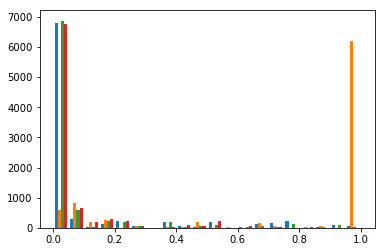

In [35]:
plt.hist(train_marginals, bins=20)
plt.show()

In [37]:
learned_table = gen_model.learned_lf_stats()
learned_cov = learned_table.values[:, 1]
learned_acc = learned_table.values[:,0]
empirical_acc = gen_model.weights.lf_accuracy
compared_stats = pd.DataFrame(np.stack((empirical_acc, learned_acc, learned_cov)).T,
                             index = [lf.__name__ for lf in total_lfs],
                             columns=['Empirical Acc.','Learned Acc.','Learned Cov.'])
compared_stats

,Empirical Acc.,Learned Acc.,Learned Cov.
lf_extractable_list,0.571060,0.511863,0.77550
lf_extractable_units,0.571015,0.510946,0.77200
lf_extractable_pattern,0.578039,0.512982,0.77800
lf_extractable_sample_length,0.572303,0.512346,0.77350
lf_extractable_number_sci,0.570534,0.506033,0.77495
lf_extractable_name,0.564594,0.503484,0.77490
lf_extractable_email_url,0.571668,0.504279,0.77705
lf_date_extraction_name,0.576089,0.514078,0.77780
lf_same_len_string,0.576813,0.507580,0.78165
lf_date_extraction_samples,0.585866,0.516828,0.77550


In [39]:
np.savetxt('train_marginals_4.csv', train_marginals, delimiter=',',)

In [40]:
df.to_csv('train_raw_4.csv')

In [41]:
denoised_labels = np.argmax(train_marginals, axis=1)
denoised_labels[:50]

array([3, 3, 3, 3, 2, 3, 1, 0, 0, 0, 0, 0, 3, 3, 3, 3, 2, 0, 0, 0, 2, 0,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1,
       0, 0, 0, 0, 0, 1])

In [42]:
corrects = 0
cm = np.zeros(5)
i = -1
for index, row in df.iterrows():
    i += 1
    if denoised_labels[i]+1 == categories[row.y_act]:
        corrects += 1
    else:
        cm[categories[row.y_act]-1] += 1

In [43]:
corrects / len(df)

0.7839143942008975

In [44]:
corrects

6813

In [45]:
cm

array([1188.,    7.,  201.,  482.,    0.])

In [62]:
from sklearn.metrics import accuracy_score

In [59]:
Y = [categories[v] for v in df.y_act.values]

In [63]:
accuracy_score(Y, modes)

0.8147508917270739

BACKUP

In [85]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [98]:
from scipy.sparse import csr_matrix

In [99]:
L_train = csr_matrix(np.array(Ls, dtype=int))
L_train

<10741x17 sparse matrix of type '<class 'numpy.int64'>'
	with 11999 stored elements in Compressed Sparse Row format>

In [100]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 5


In [101]:
gen_model.weights.lf_accuracy

array([0.71233108, 0.70567372, 0.70536448, 0.70789609, 0.70711461,
       0.70982874, 0.70698972, 0.70794799, 0.70350743, 0.72981279,
       0.72691405, 0.71446542, 0.72066986, 0.74939244, 0.72188569,
       0.81458312, 0.70733583])

In [102]:
train_marginals = gen_model.marginals(L_train)

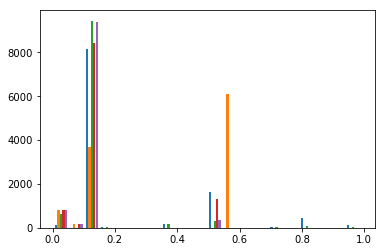

In [103]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [104]:
gen_model.learned_lf_stats()

,Accuracy,Coverage
0,0.510354,0.79968
1,0.503390,0.79652
2,0.504969,0.79688
3,0.503832,0.79852
4,0.507562,0.79612
5,0.508077,0.79736
6,0.510088,0.79696
7,0.505249,0.80016
8,0.498974,0.79932
9,0.519279,0.79880


In [107]:
train_marginals

array([[0.12260231, 0.12260231, 0.12260231, 0.50959077, 0.12260231],
       [0.12260231, 0.12260231, 0.12260231, 0.50959077, 0.12260231],
       [0.12260231, 0.12260231, 0.12260231, 0.50959077, 0.12260231],
       ...,
       [0.10989469, 0.56042125, 0.10989469, 0.10989469, 0.10989469],
       [0.10989469, 0.56042125, 0.10989469, 0.10989469, 0.10989469],
       [0.10989469, 0.56042125, 0.10989469, 0.10989469, 0.10989469]])

In [124]:
denoised_labels = np.argmax(train_marginals, axis=1)
denoised_labels[:50]

array([3, 3, 3, 3, 2, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 2, 0, 0, 0, 0, 2,
       0, 2, 0, 4, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 4, 1, 0, 0, 1, 0, 0, 0,
       4, 2, 0, 0, 0, 0])

In [126]:
corrects = 0
cm = np.zeros(5)
i = -1
for index, row in df.iterrows():
    i += 1
    if denoised_labels[i]+1 == categories[row.y_act]:
        corrects += 1
    else:
        cm[categories[row.y_act]-1] += 1

In [127]:
corrects / len(df)

0.6813145889581975

In [128]:
corrects

7318

In [129]:
cm

array([ 530.,  535.,  317.,  105., 1936.])